In [1]:
import numpy as np
import sys
sys.path.append('utils/')
from keras.models import Sequential
import keras
from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Lambda, concatenate, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.losses import categorical_crossentropy as logloss
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras import backend as K
import h5py
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:

h5f_t = h5py.File('vggmodel_train/trainset.h5', 'r')
x_train = h5f_t['dataset_1'][:]
h5f_t.close()

h5f_t = h5py.File('vggmodel_train/train_logits.h5', 'r')
train_logits = h5f_t['dataset_1'][:]
h5f_t.close()

h5f_t = h5py.File('vggmodel_train/valset.h5', 'r')
x_val = h5f_t['dataset_1'][:]
h5f_t.close()

h5f_t = h5py.File('vggmodel_train/val_logits.h5', 'r')
val_logits = h5f_t['dataset_1'][:]
h5f_t.close()


In [4]:
#data augmentation
datagen = ImageDataGenerator()  # randomly flip images
train_generator = datagen.flow(x_train,train_logits , batch_size=64)
val_generator = datagen.flow(x_val,val_logits , batch_size=64,shuffle=True)

# create student model
num_classes = 10
model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5),
                 activation='relu',
                 input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(5, 5),
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(96, activation='relu'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        4864      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        102464    
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 10, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
__________

In [5]:
temperature  = 5.0
# remove softmax
model.layers.pop()

# usual probabilities
logits = model.layers[-1].output
probabilities = Activation('softmax')(logits)

# softed probabilities
logits_T = Lambda(lambda x: x/temperature)(logits)
probabilities_T = Activation('softmax')(logits_T)

output = concatenate([probabilities, probabilities_T])
model = Model(model.input, output)
# now model outputs 512 dimensional vectors

In [6]:
def knowledge_distillation_loss(y_true, y_pred, lambda_const):    
    y_true, logits = y_true[:,:10], y_true[:,10:]
    # convert logits to soft targets
    y_soft = K.softmax(logits/temperature)
    y_pred, y_pred_soft = y_pred[:, 10:], y_pred[:, :10]    
    return lambda_const*logloss(y_true, y_pred) + logloss(y_soft, y_pred_soft)
def accuracy(y_true, y_pred):
    y_true = y_true[:,:10]
    y_pred = y_pred[:, 10:]
    return categorical_accuracy(y_true, y_pred)
def top_5_accuracy(y_true, y_pred):
    y_true = y_true[:,:10]
    y_pred = y_pred[:, 10:]
    return top_k_categorical_accuracy(y_true, y_pred)
def categorical_crossentropy(y_true, y_pred):
    y_true = y_true[:,:10]
    y_pred = y_pred[:, 10:]
    return logloss(y_true, y_pred)
def soft_logloss(y_true, y_pred):
    logits = y_true[:,10:]   
    y_soft = K.softmax(logits/temperature)
    y_pred_soft = y_pred[:, :10]    
    return logloss(y_soft, y_pred_soft)

In [7]:
lambda_const = 0.07
model.compile(
    optimizer=optimizers.SGD(lr=1e-1, momentum=0.9, nesterov=True), 
    loss=lambda y_true, y_pred: knowledge_distillation_loss(y_true, y_pred, lambda_const), 
    metrics=[accuracy, top_5_accuracy, categorical_crossentropy, soft_logloss]
)

model.fit_generator(
    train_generator, 
    steps_per_epoch=400, epochs=30, verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.01), 
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, epsilon=0.007)
    ],
    validation_data=val_generator, validation_steps=80
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Epoch 1/30
400/400 [==============================] - 109s 273ms/step - loss: 2.1538 - accuracy: 0.5015 - top_5_accuracy: 0.9336 - categorical_crossentropy: -2.2353 - soft_logloss: 2.3103 - val_loss: 2.1617 - val_accuracy: 0.4186 - val_top_5_accuracy: 0.8777 - val_categorical_crossentropy: -2.1616 - val_soft_logloss: 2.3130
Epoch 2/30
400/400 [==============================] - 119s 298ms/step - loss: 2.1494 - accuracy: 0.6010 - top_5_accuracy: 0.9721 - categorical_crossentropy: -2.3002 - soft_logloss: 2.3104 - val_loss: 2.1547 - val_accuracy: 0.5645 - val_top_5_accuracy: 0.9678 - val_categorical_crossentropy: -2.2410 - val_soft_logloss: 2.3115
Epoch 3/30
400/400 [==============================] - 104s 260ms/step - loss: 2.1485 - accuracy: 0.6316 - top_5_accuracy: 0.9759 - categorical_crossentropy: -2.3115 - soft_logloss: 2.3103 - val_loss: 2.1551 - val_accuracy: 0.5621 - val_top_5_accuracy: 0.9689 - val_categorical_crossentropy: -2.2394 - val_soft_logloss: 2.3119
Epoch 4/30
400/400 [==

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

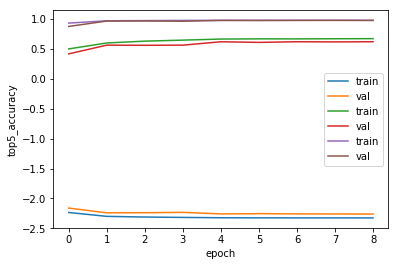

In [8]:
plt.plot(model.history.history['categorical_crossentropy'], label='train')
plt.plot(model.history.history['val_categorical_crossentropy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('logloss')
plt

plt.plot(model.history.history['accuracy'], label='train')
plt.plot(model.history.history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt

plt.plot(model.history.history['top_5_accuracy'], label='train')
plt.plot(model.history.history['val_top_5_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('top5_accuracy')
plt

In [12]:
val_generator = datagen.flow(x_val, val_logits, batch_size=64,shuffle=False)
print(model.evaluate_generator(val_generator, 80))

[2.152306741476059, 0.6216796875, 0.9783203125, -2.2616605116054416, 2.310622960329056]
